<a href="https://colab.research.google.com/github/OlaBogoyavlen/first-project/blob/master/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q --upgrade keras-nlp tensorflow
!pip install -q sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.9/947.9 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 2.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.19.1 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords') # поддерживает удаление стоп-слов
nltk.download('punkt_tab') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4')
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

from PIL import Image

from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import tensorflow as tf
import keras_nlp

from tqdm import notebook

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import sentence_transformers
from sentence_transformers import SentenceTransformer, util
import glob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
PATH = '/content/to_upload'
SEED = 12345
BLOCK = ['baby', 'child', 'kid', 'boy', 'girl', 'teenager', 'teenage']

In [ ]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
def read_df(path=PATH):


    df_train = pd.read_csv(Path(path, 'train_dataset.csv'))
    df_crowd = pd.read_csv(Path(path, 'CrowdAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
    df_expert = pd.read_csv(Path(path, 'ExpertAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'first', 'second', 'third'])
    df_queries = pd.read_csv(Path(path, 'test_queries.csv'), index_col=[0], sep='|')
    df_images = pd.read_csv(Path(path, 'test_images.csv'), sep='|')

    return df_train, df_crowd, df_expert, df_queries, df_images

In [ ]:
df_train, df_crowd, df_expert, df_queries, df_images = read_df()

In [ ]:
display(df_train.head(), df_crowd.head(), df_expert.head(), df_queries.head(), df_images.head())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

image                     query_id  share_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   count_pos  count_neg  
0          3          0  
1          0          3  
2          0          3  
3          0          3  
4          0          3

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  
0      1  
1      2  
2      2  
3      2  
4      2

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [ ]:
print('Количество уникальных фото на трейне:', df_train['image'].nunique())
print('Количество уникальных фото на тесте:', df_queries['image'].nunique())

Количество уникальных фото на трейне: 1000
Количество уникальных фото на тесте: 100


In [ ]:
print('Количество уникальных запросов на тесте:', df_queries.drop_duplicates().shape[0])

Количество уникальных запросов на тесте: 500


In [ ]:
print('Количество уникальных сочетаний фото-текст, оценённых экспертами:', df_expert.drop_duplicates().shape[0])
print('Количество уникальных сочетаний фото-текст, оценённых людьми:', df_crowd.drop_duplicates().shape[0])

Количество уникальных сочетаний фото-текст оцененных экспертами: 5822
Количество уникальных сочетаний фото-текст оцененных людьми: 47830


Проверим, все ли текстовые описания в тестовом наборе совпадают с картинками? В столце query_id зашифрована информация о номере картинки, к которой дано описание в столбце query_text.

In [ ]:
df_queries[df_queries['query_id'].str[:-2] != df_queries['image']].shape[0]

0

Проверим соответствие текстовых описаний друг другу в тестовом и тренировочном наборах.

In [ ]:
print('Уникальных текстовых описаний в трейне:', len(set(df_train['query_text'])))
print('Уникальных текстовых описаний в тесте:', len(set(df_queries['query_text'])))
print('Уникальных текстовых описаний, которые есть в обоих наборах:', len(set(df_train['query_text']) & set(df_queries['query_text'])))

Уникальных текстовых описаний в трейне: 977
Уникальных текстовых описаний в тесте: 500
Уникальных текстовых описаний, которые есть в обоих наборах: 0


Посмотрим также, нет ли пересечений по картинкам.

In [ ]:
print('Уникальных картинок в трейне:', len(set(df_train['image'])))
print('Уникальных картинок в тесте:', len(set(df_queries['image'])))
print('Уникальных картинок, которые есть в обоих наборах:', len(set(df_train['image']) & set(df_queries['image'])))

Уникальных картинок в трейне: 1000
Уникальных картинок в тесте: 100
Уникальных картинок, которые есть в обоих наборах: 0


Познакомимся с изображениями, входящими в датасеты.

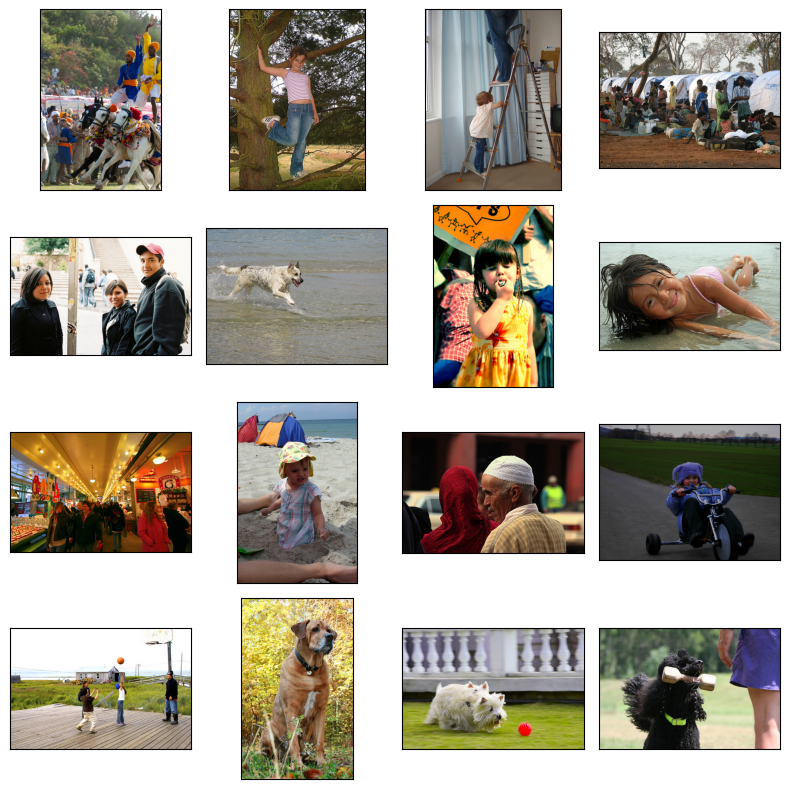

In [ ]:
samples_train = list(df_train['image'].sample(8))
samples_test = list(df_queries['image'].sample(8))

fig = plt.figure(figsize=(8,8))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(Path(PATH, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Мы загрузили и ознакомились с данными. В нашем распоряжении 1000 картинок в обучающем датасете и 100 в тестовом. Есть предобработанные файлы с сочетаниями текстовых описаний и картинок, для трейна и теста. Для трейна при этом есть как экспертные оценки соответствия (5822 шт.), так и оценки, полученные с помощью краудсорсинга (47830 шт.). Пересечений между обучающим и тестовым наборами не обнаружено.

Выполним агрегацию оценок. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставил разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст удалим из датасета.

In [ ]:
condition = (df_expert['first'] == df_expert['second']) | (df_expert['second'] == df_expert['third']) | (df_expert['third'] == df_expert['first'])
df_expert = df_expert[condition]

In [ ]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5696 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5696 non-null   object
 1   query_id  5696 non-null   object
 2   first     5696 non-null   int64 
 3   second    5696 non-null   int64 
 4   third     5696 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 267.0+ KB


Удалили 126 строк, ладно, теперь можно голосовать большинством.

In [ ]:
def expert_aggregate(row):

    if row['first'] == row['second']:
        row['expert_score'] = row['first'] / 4
    elif row['second'] == row['third']:
        row['expert_score'] = row['second'] / 4
    else:
        row['expert_score'] = row['first'] / 4
    return row

In [ ]:
df_expert = df_expert.apply(expert_aggregate, axis=1)

In [ ]:
df_scores = pd.merge(df_expert, df_crowd, how='outer', on=['image', 'query_id'])

In [ ]:
def score_aggregate(row):


    if np.isnan(row['expert_score']): # если нет экспертной оценки, берём краудсорсинговую
        row['score'] = row['share_pos']
    elif np.isnan(row['share_pos']): # наоборот
        row['score'] = row['expert_score']
    else: # если есть обе, объединяем их с весами
        row['score'] = row['expert_score'] * 0.6 + row['share_pos'] * 0.4

    return row

In [ ]:
df_scores = df_scores.apply(score_aggregate, axis=1)

In [ ]:
display(df_scores['score'].isna().value_counts())
df_scores['score'].describe()

score
False    51268
Name: count, dtype: int64

count    51268.000000
mean         0.093972
std          0.215683
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: score, dtype: float64

"Подошьём" таргет в обучающий датасет.

In [ ]:
df_train = pd.merge(df_train, df_scores[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])

Заполним пропуски в описании.

In [ ]:
to_fill = df_train[df_train['query_text'].notna()]

In [ ]:
def fill_text(row):

    if pd.isnull(row['query_text']):
        texts = to_fill[to_fill['query_id'] == row['query_id']]['query_text']
        if len(texts) > 0:
            row['query_text'] = texts.iloc[0]

    return row

In [ ]:
df_train = df_train.apply(fill_text, axis=1)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       51268 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


Удалим строки без описаний и без оценки.

In [ ]:
df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50159 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50159 non-null  object 
 1   query_id    50159 non-null  object 
 2   query_text  50159 non-null  object 
 3   score       50159 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


Проверка данных. В некоторых странах, где работает наша компания, действуют ограничения по обработке изображений: поисковым сервисам запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе (но не исключительно) тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.
В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:
⎪ This image is unavailable in your country in compliance with local laws
Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Для этого воспользуемся текстовыми описаниями файлов.

Объявим список слов для поиска запрещённого контента.

Очистим, токенизируем и лемматизируем текст, чтобы было легче искать запросы связанные с детьми. Отметим в обучающем наборе картинки, которые следует удалить.

In [ ]:
lemmatize = nltk.WordNetLemmatizer()

def get_lemmas(text):


    text = re.sub('[^a-zA-Z]', ' ', text).lower() # удаляем неалфавитные символы, приводим к нижнему регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatize.lemmatize(word) for word in text] # лемматизируем слова

    return text

def cleaning(row):


    text = get_lemmas(row['query_text'])
    if [i for i in text if i in BLOCK]:
        row['to_block'] = 1
    else:
        row['to_block'] = 0

    return row

In [ ]:
df_train = df_train.apply(cleaning, axis=1)

Посмотрим, какие запросы оказались заблокированы.

In [ ]:
df_train[df_train['to_block'] == 1]['query_text'].sample(10).unique()

array(['Three girls in colorful outfits are dancing under a stage light .',
       'A young boy dressed in a red uniform kicks the soccer ball on the field as another child in blue watches from behind .',
       'a girl paints the road .',
       'Kids are waiting at the bottom of a staircase attached to a brick building .',
       'A boy climbs up some rocks .',
       'A row of legs and black boots with a boy sitting at the end of the row .',
       'Little girl in bare feet sitting in a circle .',
       'A young asian girl with a woman plays with a blue ball in a part setting .',
       'Girls in pink dresses walk toward a cruise ship',
       'A woman with holding a young girl playing with bubbles at a picnic .'],
      dtype=object)

Какие картинки соответствуют этим запросам?

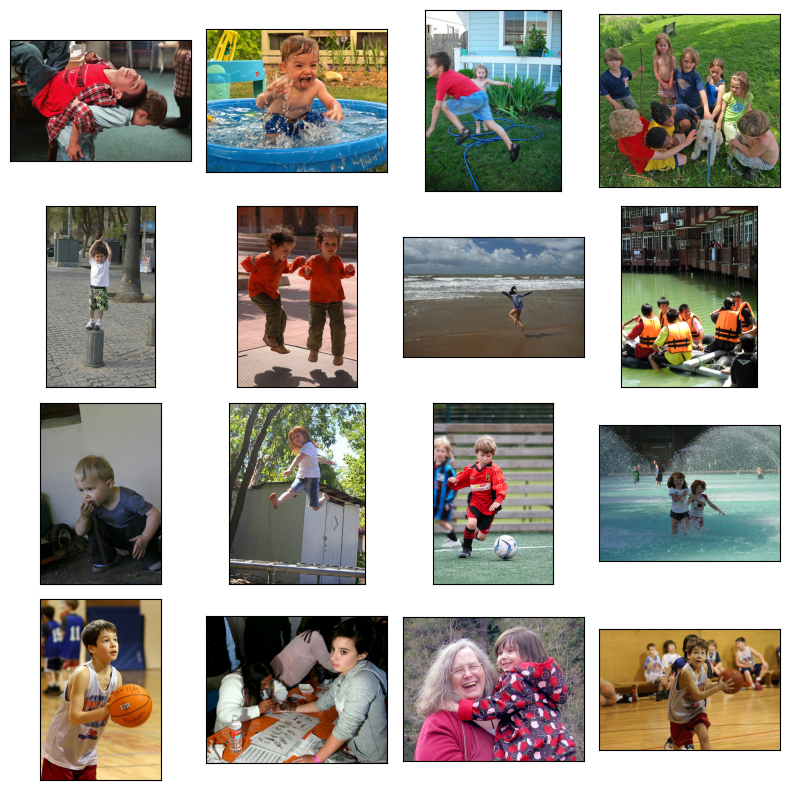

In [ ]:
samples = list(df_train[df_train['to_block'] == 1]['query_id'].sample(16))
samples = [i[:-2] for i in samples]

fig = plt.figure(figsize=(8,8))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Удалим эти строки из набора данных.

In [ ]:
df_train.drop(df_train[df_train['to_block'] == 1].index, inplace=True, errors='ignore')
df_train.drop(columns='to_block', inplace=True, errors='ignore')
df_train.reset_index(inplace=True, drop=True)

In [ ]:
display(df_train.head(), df_queries.head())
df_train.info()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   
2  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   
3  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2   
4  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2   

                                          query_text  score  
0  A woman is signaling is to traffic , as seen f...    1.0  
1  A woman wearing black clothes , a purple scarf...    0.0  
2  An older woman with blond hair rides a bicycle...    0.0  
3  A woman wearing a white glove peers over the c...    0.0  
4      A man taking a picture with a silver camera .    0.0

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36088 entries, 0 to 36087
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       36088 non-null  object 
 1   query_id    36088 non-null  object 
 2   query_text  36088 non-null  object 
 3   score       36088 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [ ]:
df_queries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


Проверили данные на содержание запрещенных слов и удалили из обучающего набора все строки, содержащие такие данные.

Векторизация изображений."...Поэтому стоит обратиться к свёрточным сетям: они позволяют «выделить» главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet."

In [ ]:
def load_train(path=PATH): # загрузчик данных для обучения


    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=Path(path, 'train_images'),
        x_col='image',
        y_col='score',
        target_size=(150, 150),
        batch_size=16,
        class_mode='input',
        seed=SEED)

    return train_gen_flow

Проверим выдачу.

Found 36088 validated image filenames.


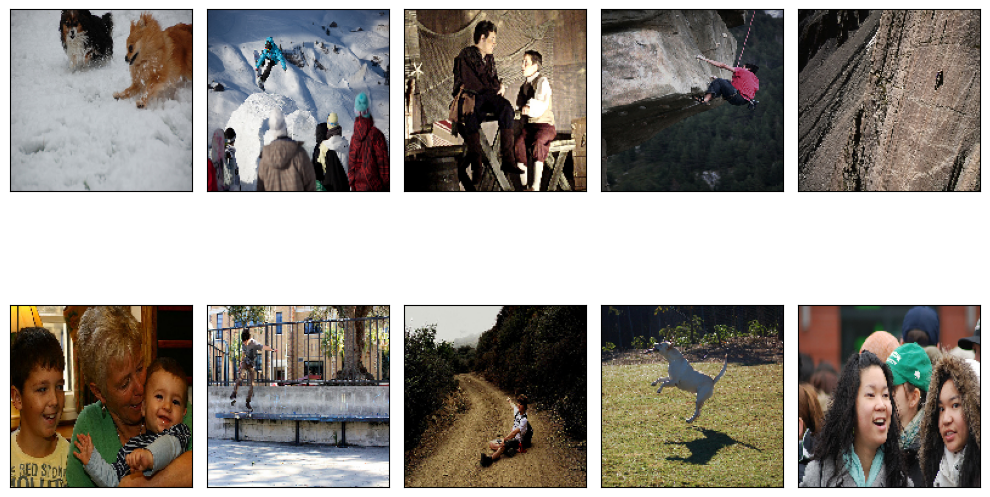

In [ ]:
flow_train = load_train()
features, target = next(flow_train)

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Создадим модель.

In [ ]:
def create_model(input_shape=(150, 150, 3)):


    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

In [ ]:
def vectorize_pictures(model, train_data):


    predictions = model.predict(train_data)

    return predictions

In [ ]:
pict_embeds = vectorize_pictures(create_model(), load_train())

Found 36088 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2256/2256 ━━━━━━━━━━━━━━━━━━━━ 2687s 1s/step


In [ ]:
pict_embeds.shape

(36088, 2048)

Векторизация текстов.

In [ ]:
bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en')

100%|██████████| 457/457 [00:00<00:00, 641kB/s]


100%|██████████| 414M/414M [00:03<00:00, 131MB/s]


In [ ]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

In [ ]:
def vectorize_text(model, data, preprocessor=preprocessor, batch_size=32, bar=True, verbose=0):


    embeddings = []
    tokenized = preprocessor(data)

    if bar:
        for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])

    else:
        for i in range(tokenized['token_ids'].shape[0] // batch_size + 1):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])

    return np.concatenate(embeddings)

In [135]:
text = list(df_train['query_text'].unique())

In [136]:
text_embeds = vectorize_text(model=bert, data=text)

  0%|          | 0/22 [00:00<?, ?it/s]

In [141]:
dict = dict(zip(df_train['query_text'].unique(), text_embeds))

In [143]:
df_train['text_embeds'] = df_train['query_text'].map(dict)


In [160]:
text_embeds_final = df_train['text_embeds']

In [164]:
embeds_final = pd.DataFrame(df_train['text_embeds'].tolist(), index=text_embeds_final.index).values

In [165]:
embeds_final.shape

(36088, 768)

Слава Богу. Объединение векторов

Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной.

In [166]:
X = np.concatenate((pict_embeds, embeds_final), axis=1)
X.shape

(36088, 2816)

In [167]:
y = np.array(df_train['score'])
y.shape

(36088,)

In [168]:
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)

with open('y.pickle', 'wb') as f:
    pickle.dump(y, f)

Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом `GroupShuffleSplit` из библиотеки `sklearn.model_selection`.

Сначала получим обучающую и тестовые выборки.

In [169]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=SEED)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=df_train['image']))

In [170]:
X_train, X_test = X[train_indices], X[test_indices]

In [171]:
y_train, y_test = y[train_indices], y[test_indices]

In [172]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

В качестве baseline'а попробуем модель линейной регрессии.

Лучше будет воспользоваться в качестве метрики MAE или RMSE, при этом RMSE будет активнее реагировать на большие выбросы предсказаниях (т.к. цель и предсказания возводятся в квадрат до вычисления разницы). Остановимся на RMSE.

In [173]:
%%time
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
score = cross_val_score(
    model, X_train, y_train, groups=df_train['image'].loc[train_indices],
    scoring='neg_root_mean_squared_error',
    cv=GroupShuffleSplit(random_state=SEED)
).mean()
abs(score).round(decimals=3)

CPU times: user 3min 9s, sys: 2.15 s, total: 3min 11s
Wall time: 1min 56s


np.float64(0.225)

In [178]:
pred = model.predict(X_test)
round(np.sqrt(mean_squared_error(y_test, pred)), 3)

np.float64(0.223)

LinearSVR

Попробуем модель на основе метода опорных векторов.

Зададим параметры сетки для перебора в GridSearch.

In [179]:
model = LinearSVR(random_state=SEED)

param_grid = {
    'loss':['squared_epsilon_insensitive'],
    'C':[1]
}

gs_svr = GridSearchCV(
    model,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=GroupShuffleSplit(n_splits=3, random_state=SEED),
    verbose=1
)

In [180]:
%time gs_svr.fit(X_train, y_train, groups=df_train['image'].loc[train_indices])
None

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 14min 57s, sys: 3.11 s, total: 15min
Wall time: 39min 22s


In [181]:
pd.DataFrame(gs_svr.cv_results_)[['param_C', 'param_loss', 'mean_test_score', 'rank_test_score']].round(decimals=3)

param_C                   param_loss  mean_test_score  rank_test_score
0        1  squared_epsilon_insensitive           -0.223                1

In [185]:
pred = gs_svr.predict(X_test)
round(np.sqrt(mean_squared_error(y_test, pred)), 3)

np.float64(0.223)

NeuralNetwork

Создадим трёхслойную нейронную сеть.

In [187]:
X_train.shape

(28883, 2816)

In [188]:
NN = Sequential()
NN.add(Dense(2816, input_shape=(2816,), activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(256, activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=1e-5)

NN.compile(optimizer=optimizer, loss='mean_squared_error',
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

NN.build()

NN.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2816)           │     7,932,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2816)           │        11,264 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       721,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,666,369 (33.06 MB)

 Trainable params: 8,660,225 (33.04 MB)

 Non-trainable params: 6,144 (24.00 KB)

In [189]:
NN.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32, epochs=10,
    verbose=2, shuffle=True
    )

Epoch 1/10
903/903 - 96s - 107ms/step - loss: 0.2086 - root_mean_squared_error: 0.4567 - val_loss: 0.0985 - val_root_mean_squared_error: 0.3138
Epoch 2/10
903/903 - 140s - 155ms/step - loss: 0.0733 - root_mean_squared_error: 0.2708 - val_loss: 0.0777 - val_root_mean_squared_error: 0.2788
Epoch 3/10
903/903 - 91s - 101ms/step - loss: 0.0505 - root_mean_squared_error: 0.2248 - val_loss: 0.0746 - val_root_mean_squared_error: 0.2731
Epoch 4/10
903/903 - 91s - 101ms/step - loss: 0.0428 - root_mean_squared_error: 0.2069 - val_loss: 0.0725 - val_root_mean_squared_error: 0.2693
Epoch 5/10
903/903 - 92s - 101ms/step - loss: 0.0397 - root_mean_squared_error: 0.1994 - val_loss: 0.0739 - val_root_mean_squared_error: 0.2718
Epoch 6/10
903/903 - 92s - 101ms/step - loss: 0.0404 - root_mean_squared_error: 0.2010 - val_loss: 0.0732 - val_root_mean_squared_error: 0.2705
Epoch 7/10
903/903 - 93s - 102ms/step - loss: 0.0400 - root_mean_squared_error: 0.1999 - val_loss: 0.0667 - val_root_mean_squared_error

Выбираем нейронную сеть.

Получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

Создадим загрузчик тестовых изображений.

In [190]:
def load_test(path=PATH) -> ImageDataGenerator:

    '''загрузчик данных для тестирования'''

    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_images,
        directory=Path(path, 'test_images'),
        x_col='image',
        y_col=None,
        target_size=(150, 150),
        batch_size=16,
        class_mode='input',
        seed=SEED)

    return train_gen_flow

In [191]:
%%time

pict_embeds_test = vectorize_pictures(create_model(), load_test())
pict_embeds_test.shape

Found 100 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
CPU times: user 19.7 s, sys: 928 ms, total: 20.6 s
Wall time: 14.3 s


(100, 2048)

In [192]:
def get_picture(text) -> None:

    '''Проверяем легальность запроса, получаем наиболее похожие картинки,
    если описание среди оригинальных картинок - добавляем последней верную'''

    if [i for i in get_lemmas(text) if i in BLOCK]: #проверяем не нужно ли вывести на экран заглушку
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        print('This image is unavailable in your country in compliance with local laws.')
        print('')
    else:
        text_embed = vectorize_text(model=bert, data=[text], bar=False) #получаем эмбеддинг текста
        X = np.concatenate(( #объединяем вектора тестовых картинок с эмбеддингом текста
            pict_embeds_test,
            np.resize(text_embed, (pict_embeds_test.shape[0],768))),
            axis=1)
        X = scaler.transform(X)
        predictions = NN.predict(X) #получаем предсказания оценок экспертов
        df = pd.concat((df_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1) #добавляем оценки к номерам картинок
        top = list(df.sort_values(by='pred', ascending=False)['image'].head(5)) #получили топ 5 имён файлов с картинками
        top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5)) #получили топ 5 оценок

        print('')
        print('-' * 20, text, '-' * 20)
        print('')

        fig = plt.figure(figsize=(15,5)) #выводим на экран 5 наиболее похожих картинок
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
            image = Image.open(Path(PATH, 'test_images', top[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        if text in list(df_queries['query_text']): #если текст был в исходном файле с описаниями - добавляем оригинальную картинку
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(PATH, 'test_images', df_queries.iloc[df_queries[df_queries['query_text'] == text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        plt.show()

    return None

In [193]:
samples = df_queries.sample(10)
text_test = list(samples['query_text'])
text_test

['A large bird spreading his wings in flight over a body of water .',
 'A watercraft speeds through the water .',
 'Two young girls on a playground .',
 'A boy wearing blue shorts is bouncing a basketball in front of the net .',
 'A dog is jumping into a pool for a swim competition',
 'a tan dog wearing a multicolored color running on the beach',
 'One person in a crowd of people , wearing a blue wig',
 'Two dogs are wrestling in a field .',
 'a large group of young people all dressed in white tops and green bottoms',
 'Two girls in pink are playing on yellow playground bars .']

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

-------------------- A large bird spreading his wings in flight over a body of water . --------------------



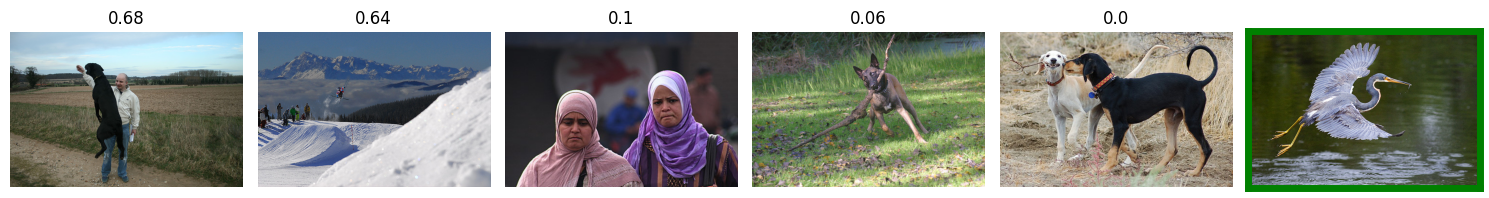

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

-------------------- A watercraft speeds through the water . --------------------



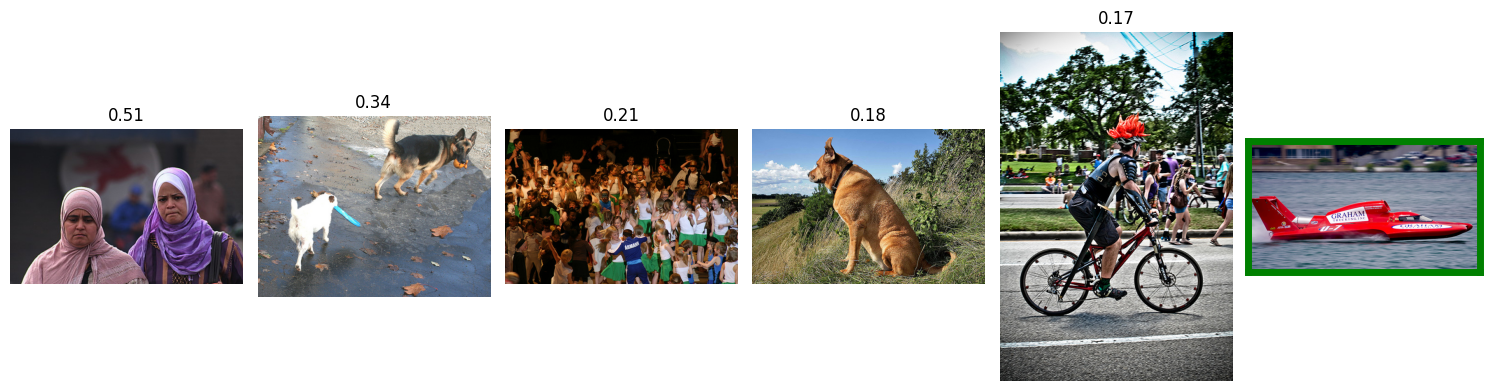


-------------------- Two young girls on a playground . --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- A boy wearing blue shorts is bouncing a basketball in front of the net . --------------------

This image is unavailable in your country in compliance with local laws.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

-------------------- A dog is jumping into a pool for a swim competition --------------------



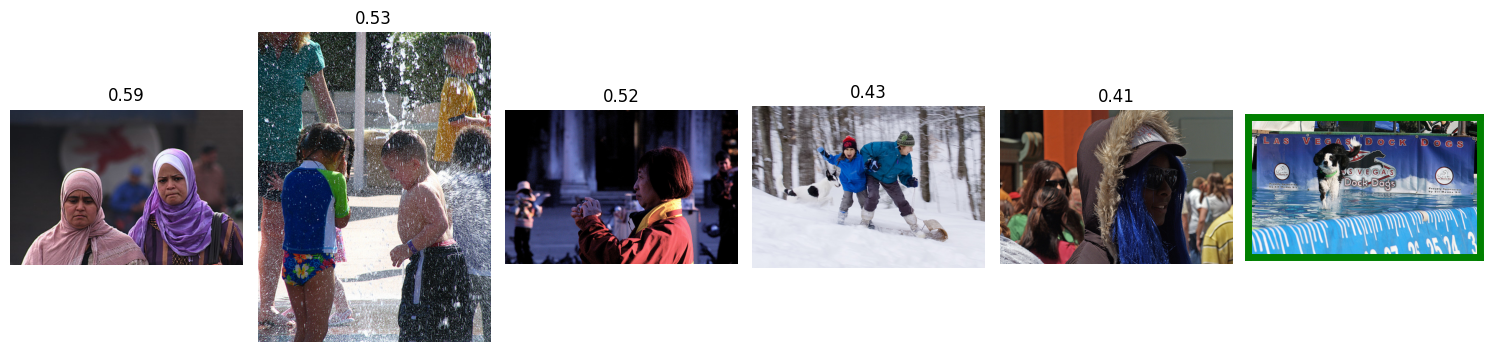

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

-------------------- a tan dog wearing a multicolored color running on the beach --------------------



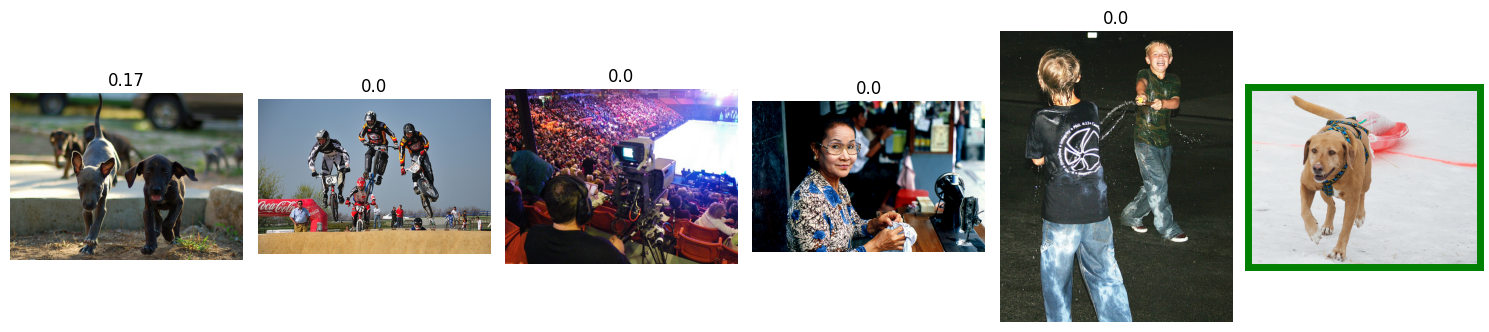

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

-------------------- One person in a crowd of people , wearing a blue wig --------------------



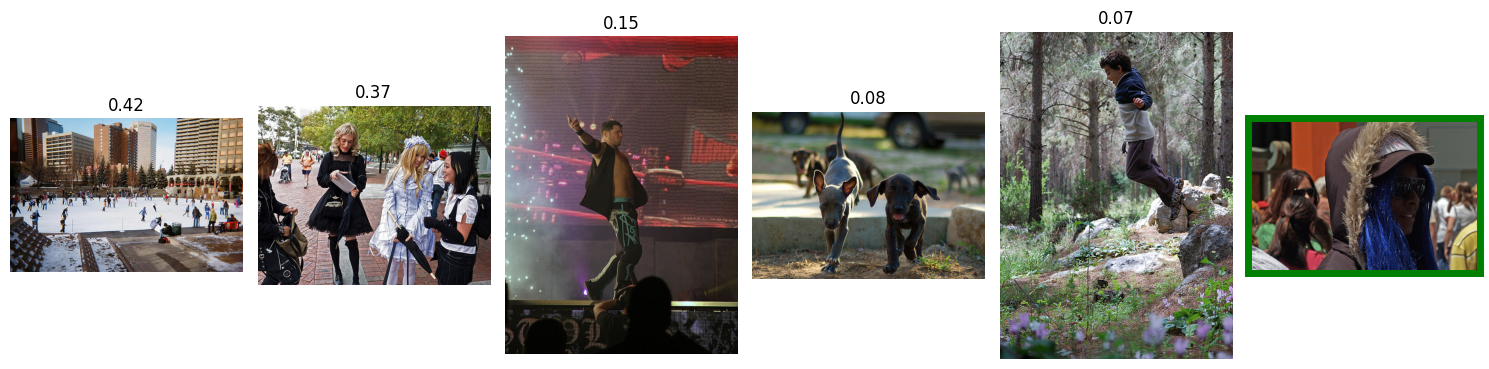

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

-------------------- Two dogs are wrestling in a field . --------------------



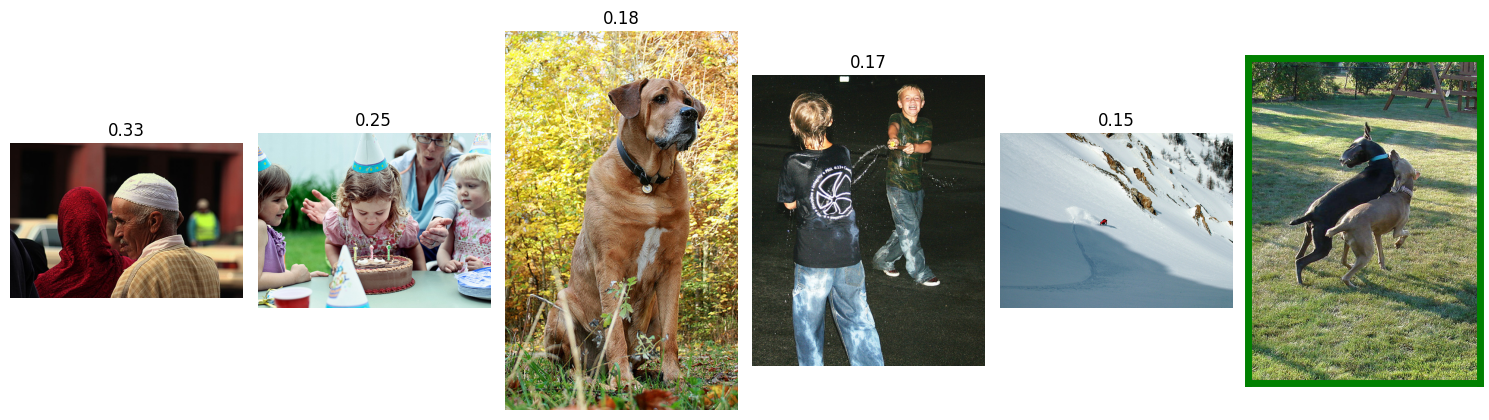

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

-------------------- a large group of young people all dressed in white tops and green bottoms --------------------



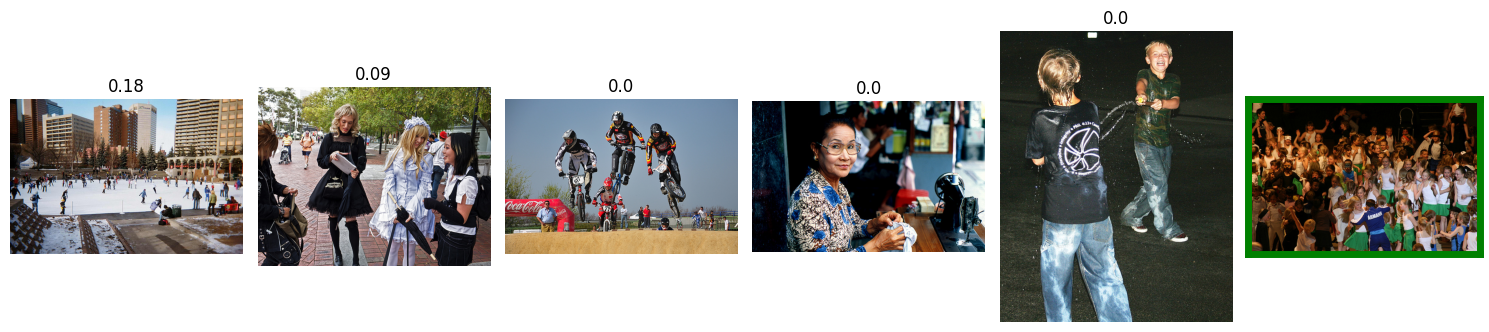


-------------------- Two girls in pink are playing on yellow playground bars . --------------------

This image is unavailable in your country in compliance with local laws.



In [194]:
for text in text_test:
    get_picture(text)

Заключение.

В данном проекте мы разработали демонстрационную версию поиска изображений по текстовому запросу.

В ходе работы для векторизации изображений мы использовали сеть ResNet50, а для текстовых эмбеддингов BERT base cased EN.

После объединения признаков и выделения целей (экспертные оценки схожести описания и картинок), мы исследовали три модели для оценки схожести:

   * LinearRegression
   * LinearSVR
   * трёхслойную нейронную сеть

Лучше всего себя показала нейронная сеть, с ней мы провели тесты.

В конце работы мы написали функцию которая по текстовому описанию возвращает 5 наиболее похожих картинок и протестировали её на предложенном наборе тестовых картинок.

К сожалению, лишь в некоторых случаях в топ5 выдачи попадает верная картинка и, чуть чаще, попадают картинки связанные тематически.